# Homework 6, Assignment 1

### Can we measure and predict energy use based on observables that are easier to be acquired?

Using light as a proxy for occupancy, and occupancy as a good predictor of energy consumption.


In [32]:
# set working environment
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.tools.plotting import scatter_matrix
%pylab inline

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

PUIDATA = os.getenv("PUIDATA")

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIDATA = "/home/cusp/kal573/PUIdata"

Can we measure and predict energy use based on observables that are easier to be acquired?

Light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

### First obtain the data

In [3]:
# use geopandas to read the csv
nrg = gp.GeoDataFrame.from_csv(PUIDATA + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [4]:
# read building data (PLUTO)
bsize = gp.GeoDataFrame.from_file(PUIDATA + "/Manhattan/MNMapPLUTO.shp")
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82b4566090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f82a95d1710>]], dtype=object)

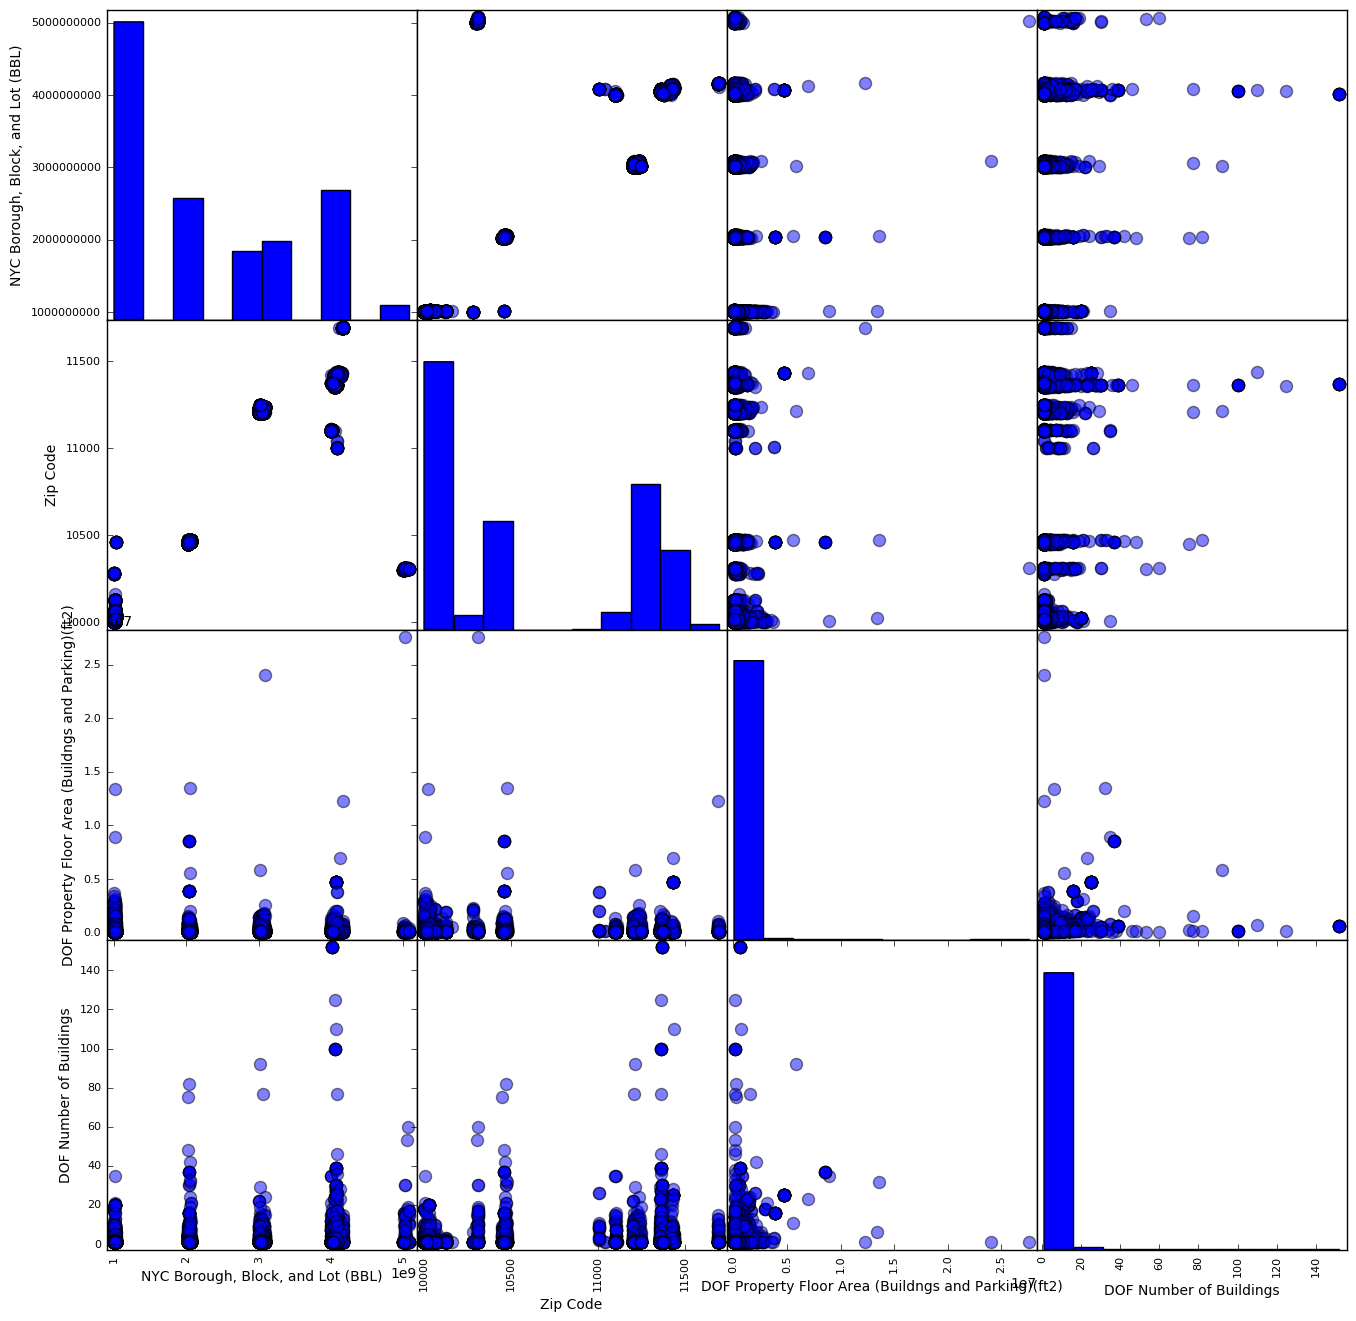

In [5]:
# make intial scatter matrix of nrg data
scatter_matrix (nrg, s=300, figsize=(16, 16))

In [6]:
# clean data to just the columns we need for this analysis
nrg_subset = gp.GeoDataFrame(nrg.loc[:,["Site EUI(kBtu/ft2)", "NYC Borough, Block, and Lot (BBL)", "Reported Property Floor Area (Building(s)) (ft²)"]])
nrg_subset.head()

,Site EUI(kBtu/ft2),"NYC Borough, Block, and Lot (BBL)",Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,NaN,1.000410e+09,918919
14354,NaN,4.021460e+09,NaN
12150,NaN,2.027620e+09,64200
12590,NaN,1.006700e+09,NaN
15591,NaN,2.048300e+09,50000


In [7]:
# subset builidng size dataseet
bsize_subset = gp.GeoDataFrame(bsize.loc[:,["BBL", "UnitsTotal"]])
bsize_subset.head()

,BBL,UnitsTotal
0,1.002760e+09,7
1,1.002280e+09,5
2,1.005900e+09,4
3,1.005890e+09,1
4,1.005310e+09,0


In [8]:
# define a function to convert data to float
def canconvert(mydata):
    '''
    function taken from dr. federica's skeleton notebook
    converts data into float type
    '''
    try :
        float(mydata)
        return True
    except ValueError:
        return False


In [9]:
bsize.BBL.astype(float)

0        1.002760e+09
1        1.002280e+09
2        1.005900e+09
3        1.005890e+09
4        1.005310e+09
5        1.011860e+09
6        1.004940e+09
7        1.005580e+09
8        1.001808e+09
9        1.005820e+09
10       1.004680e+09
11       1.008090e+09
12       1.002040e+09
13       1.002270e+09
14       1.001368e+09
15       1.006120e+09
16       1.004230e+09
17       1.004100e+09
18       1.008980e+09
19       1.008970e+09
20       1.007870e+09
21       1.003850e+09
22       1.003870e+09
23       1.009110e+09
24       1.004070e+09
25       1.004360e+09
26       1.008850e+09
27       1.007760e+09
28       1.000190e+09
29       1.006220e+09
             ...     
42756    1.017090e+09
42757    1.011710e+09
42758    1.011090e+09
42759    1.015320e+09
42760    1.010518e+09
42761    1.006990e+09
42762    1.007460e+09
42763    1.007760e+09
42764    1.002460e+09
42765    1.019120e+09
42766    1.018520e+09
42767    1.017270e+09
42768    1.007050e+09
42769    1.022151e+09
42770    1

In [10]:
# taken from skeleton notebook
# utilizes the function canconvert from above to convert data to float or NaN
indx = (np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg_subset['Site EUI(kBtu/ft2)'][~indx] = float(NaN)

invalid entries changed to NaN 15513


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
indx1 = (np.vectorize(canconvert)(nrg['NYC Borough, Block, and Lot (BBL)']))
print ("invalid entries changed to NaN %d"%sum(indx1))
nrg_subset['NYC Borough, Block, and Lot (BBL)'][~indx1] = float(NaN)

invalid entries changed to NaN 16170


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [12]:
indx = (np.vectorize(canconvert)(nrg["Reported Property Floor Area (Building(s)) (ft²)"]))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg_subset["Reported Property Floor Area (Building(s)) (ft²)"][~indx] = float(NaN)

invalid entries changed to NaN 15430


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [13]:
print (nrg_subset['NYC Borough, Block, and Lot (BBL)'].astype(float))

Record Number
12086    1.000410e+09
14354    4.021460e+09
12150    2.027620e+09
12590    1.006700e+09
15591    2.048300e+09
12135    2.006120e+09
8523     3.050770e+09
15920    3.065710e+09
14241    4.004490e+09
15925    3.072240e+09
9685     3.087210e+09
7540     3.008640e+09
14360    4.022370e+09
10588    4.024310e+09
14423    4.031680e+09
12515    1.004370e+09
3028     1.013110e+09
14609    4.100970e+09
12096    1.006460e+09
6666     2.033970e+09
8914     3.058870e+09
11586    4.097150e+09
11714    4.103360e+09
14307    4.015250e+09
12761    1.009220e+09
12091    1.001242e+09
16027    4.042820e+09
13378    2.031170e+09
14911    1.007400e+09
15103    1.012770e+09
             ...     
14559    4.078700e+09
14560    4.078800e+09
14748    5.024508e+09
14753    5.024508e+09
13582    2.056428e+09
13947    3.046170e+09
14777    5.070408e+09
14779    5.070488e+09
14409    4.030880e+09
13262    2.025110e+09
13261    2.025070e+09
12523    1.004758e+09
12529    1.004860e+09
12536    1.005000e

### Merge the dataset


In [14]:
# first rename column in energy data to match column in size data
nrg_new = nrg_subset.rename(columns={'NYC Borough, Block, and Lot (BBL)': 'BBL'})
nrg_new.head()

,Site EUI(kBtu/ft2),BBL,Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,NaN,1.000410e+09,918919
14354,NaN,4.021460e+09,NaN
12150,NaN,2.027620e+09,64200
12590,NaN,1.006700e+09,NaN
15591,NaN,2.048300e+09,50000


In [15]:
# merge two datasets using BBL join field
bblnrgdata = pd.merge(nrg_new, bsize_subset, on='BBL')
bblnrgdata.head()

,Site EUI(kBtu/ft2),BBL,Reported Property Floor Area (Building(s)) (ft²),UnitsTotal
0,NaN,1.006700e+09,NaN,1
1,NaN,1.004370e+09,NaN,4
2,125.4,1.013110e+09,330000,56
3,NaN,1.009220e+09,NaN,148
4,NaN,1.007400e+09,68329,1


In [16]:
# populate total energy field
bblnrgdata["TotalEnergy"] = bblnrgdata['Site EUI(kBtu/ft2)'].astype(float) * bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82bfd63850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f82b4814810>]], dtype=object)

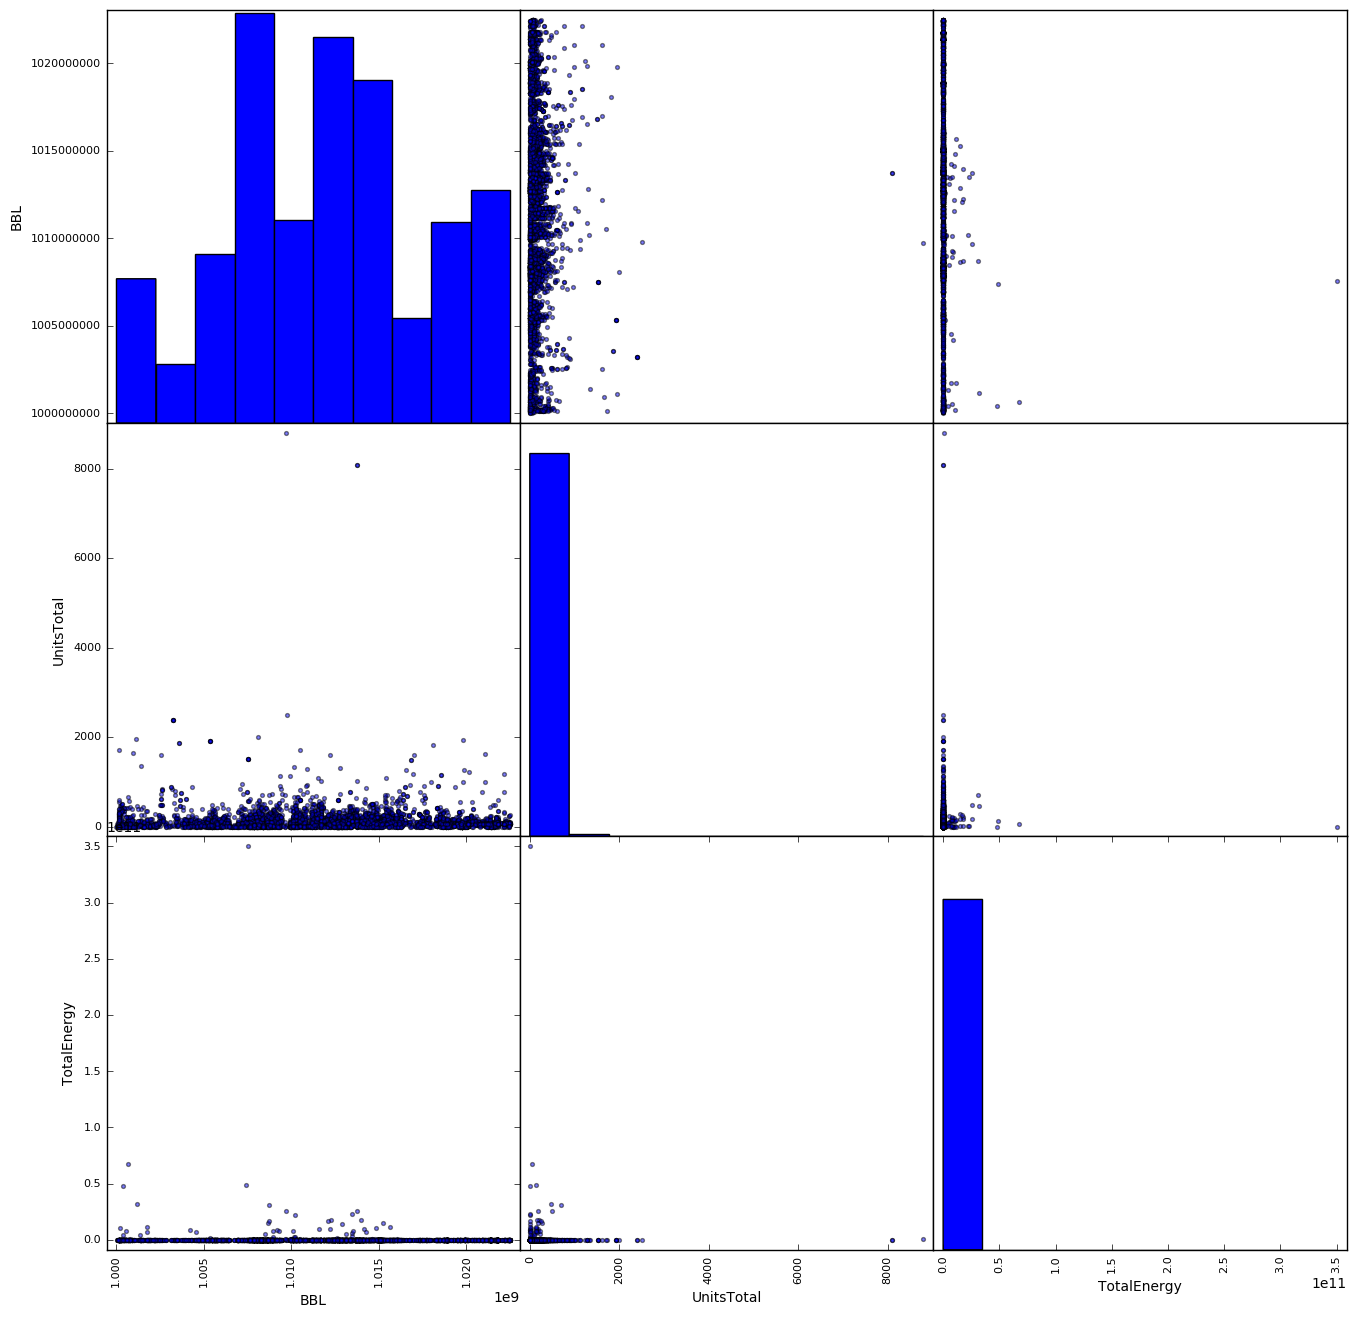

In [17]:
# display scatter matrix of new dataset
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

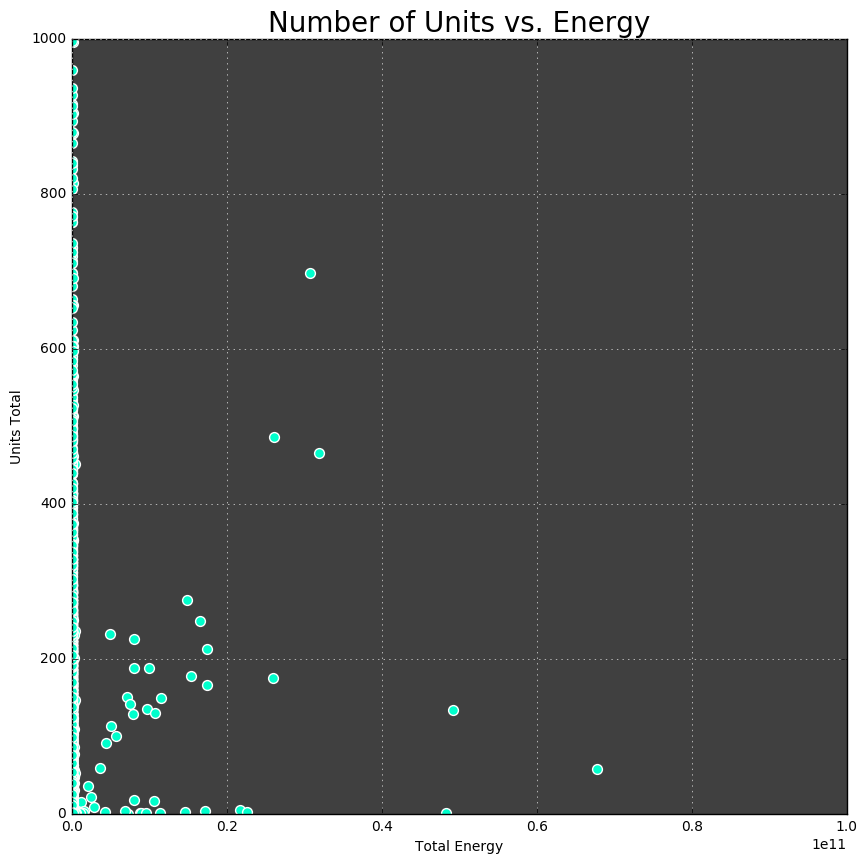

In [18]:
# limit axes to show the data properly
fig = pl.figure(figsize(10,10))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#404040')
pl.scatter(bblnrgdata['TotalEnergy'].astype(float), bblnrgdata['UnitsTotal'], s=50, facecolors='#00ffcc', edgecolors='white')
pl.xlim(0,1e11)
pl.ylim(0,1000)
pl.ylabel('Units Total')
pl.xlabel('Total Energy')
pl.grid(color = '#e6e6e6')
pl.title("Number of Units vs. Energy", fontsize = 20)


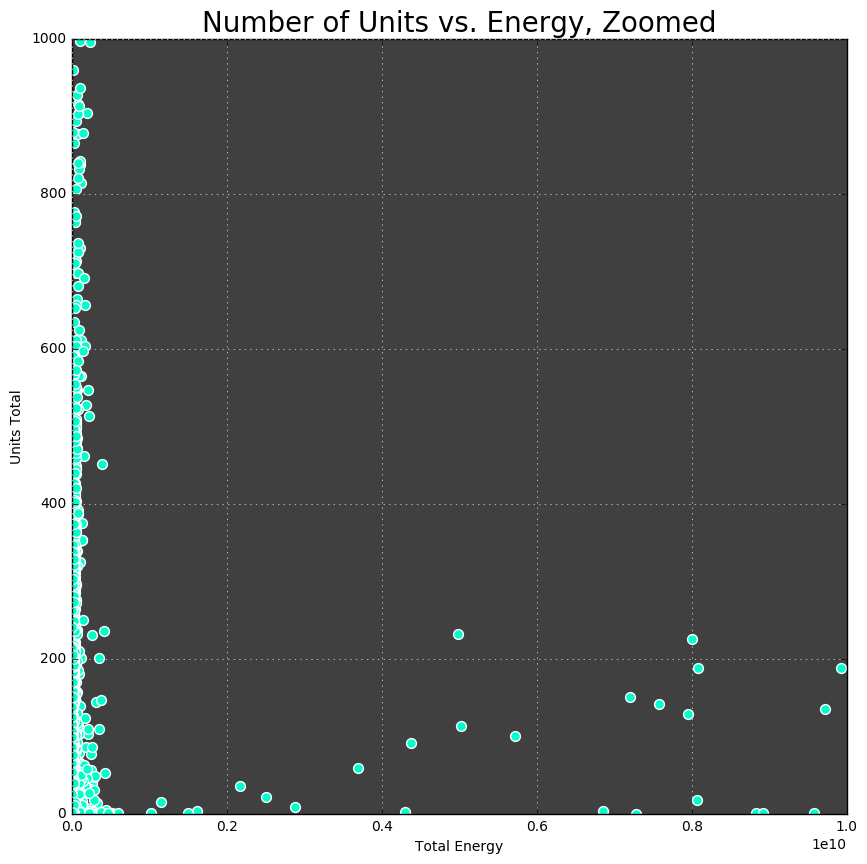

In [19]:
# zoom into the plot to analyze data
fig = pl.figure(figsize(10,10))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#404040')
ax = pl.scatter(bblnrgdata['TotalEnergy'], bblnrgdata['UnitsTotal'], s=50, facecolors='#00ffcc', edgecolors='white')
pl.xlim(0,1e10)
pl.ylim(0,1000)
pl.ylabel('Units Total')
pl.xlabel('Total Energy')
pl.grid(color = '#e6e6e6')
pl.title("Number of Units vs. Energy, Zoomed", fontsize = 20)

In [20]:
# cut data to prepare for log plot
bblnrgdata_cut = bblnrgdata[(bblnrgdata['TotalEnergy']>1000) & (bblnrgdata['TotalEnergy']<1e10) & (bblnrgdata['UnitsTotal']>=10) &
                           (bblnrgdata['UnitsTotal']<1000)]


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/tools/plotting.py:968: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


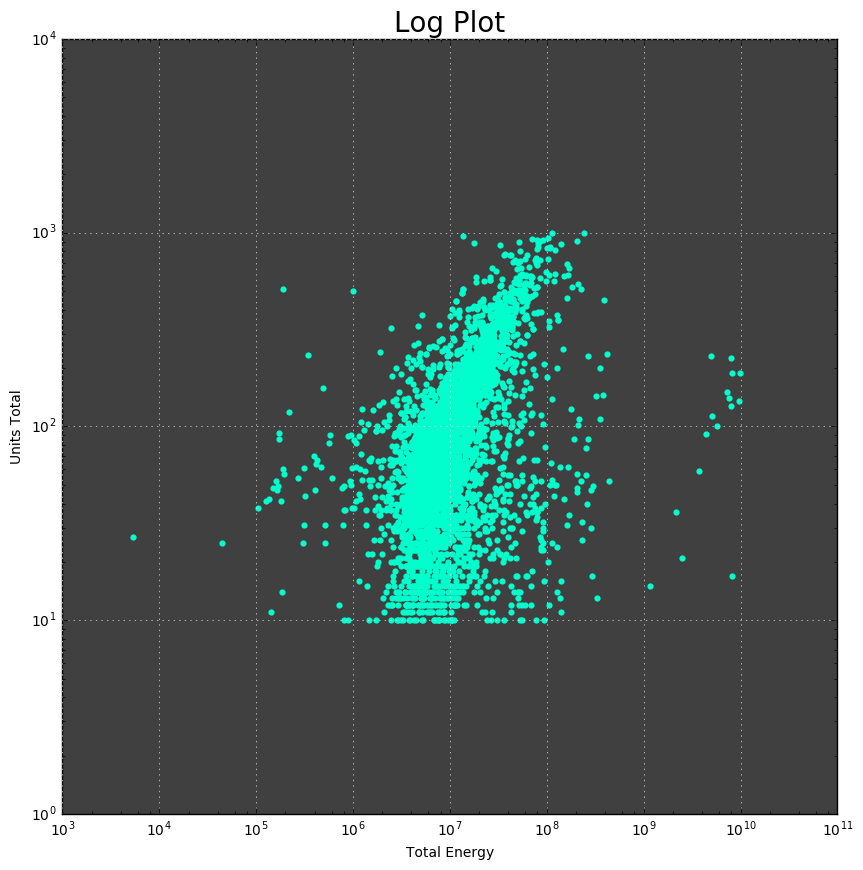

In [21]:
# log plot: x = total energy, y = units total
ax = bblnrgdata_cut.plot(x = 'TotalEnergy', y = 'UnitsTotal', kind = 'scatter', loglog=True,lw=0, figsize = (10,10), colors = '#00ffcc')
ax.set_axis_bgcolor("#404040")
pl.ylabel('Units Total')
pl.xlabel('Total Energy')
pl.grid(color = '#e6e6e6')
pl.title("Log Plot", fontsize = 20)

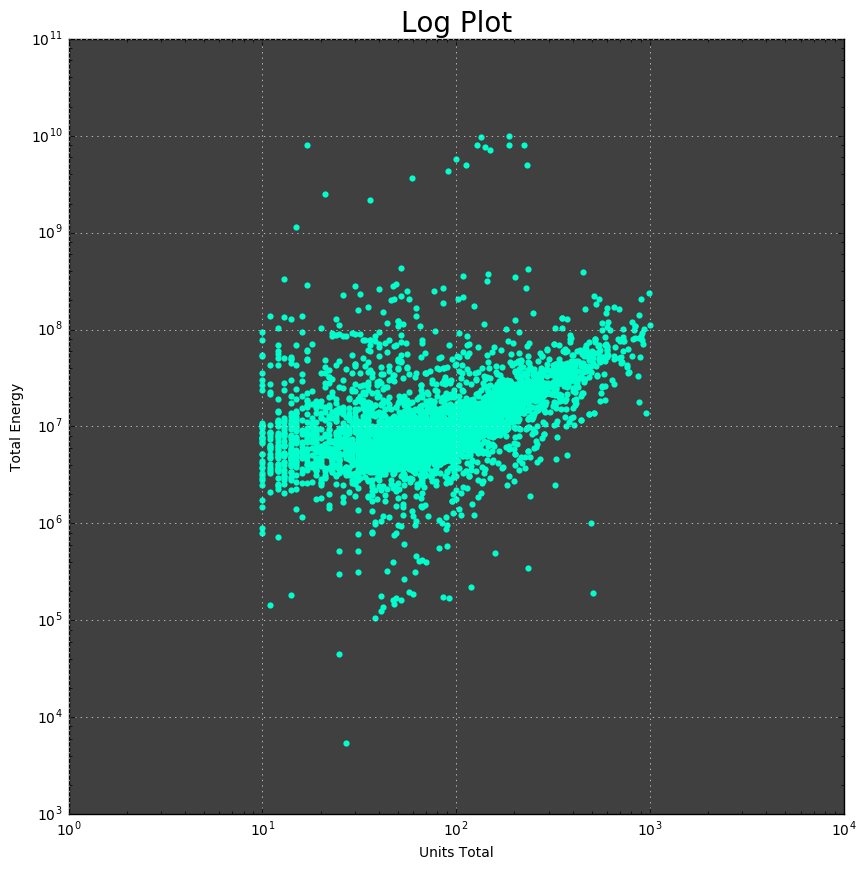

In [95]:
# log plot: x = units total, y = total energy (transposed)

ax = bblnrgdata_cut.plot(x = 'UnitsTotal', y = 'TotalEnergy', kind = 'scatter', loglog=True,lw=0,figsize=(10,10), colors = '#00ffcc')
ax.set_axis_bgcolor("#404040")
pl.ylabel('Total Energy')
pl.xlabel('Units Total')
pl.grid(color = '#e6e6e6')
pl.title("Log Plot", fontsize = 20)

In [23]:
# create linear regression model using sm.OlS function
X = sm.add_constant(np.log10(bblnrgdata_cut['UnitsTotal']))
linmodel = sm.OLS(np.log10(bblnrgdata_cut['TotalEnergy']), X, missing='drop').fit()

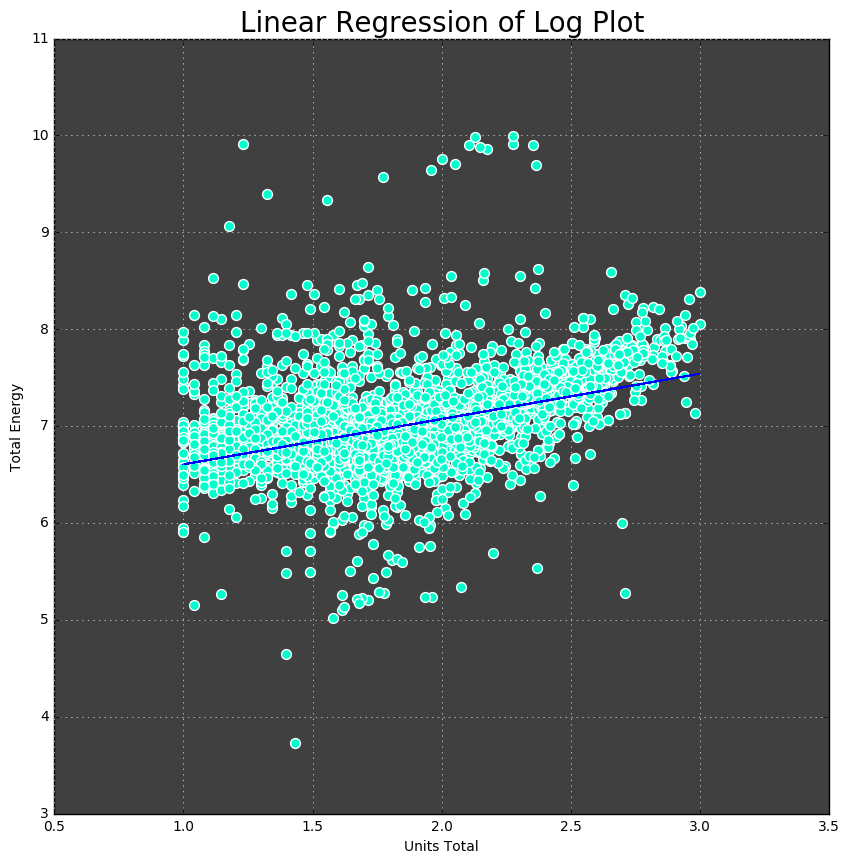

In [96]:
# plot the linear regression on top of the scatter log plot
fig = pl.figure(figsize(10,10))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#404040')
pl.scatter(np.log10(bblnrgdata_cut['UnitsTotal']), np.log10(bblnrgdata_cut['TotalEnergy']), s=50, facecolors='#00ffcc', edgecolors='white')
pl.plot(np.log10(bblnrgdata_cut['UnitsTotal']), linmodel.predict())
pl.ylabel('Total Energy')
pl.xlabel('Units Total')
pl.grid(color = '#e6e6e6')
pl.title("Linear Regression of Log Plot", fontsize = 20)

In [25]:
# create second linear model, for transpose of data
X1 = sm.add_constant(np.log10(bblnrgdata_cut['TotalEnergy']))
linmodel1 = sm.OLS(np.log10(bblnrgdata_cut['UnitsTotal']), X1, missing='drop').fit()

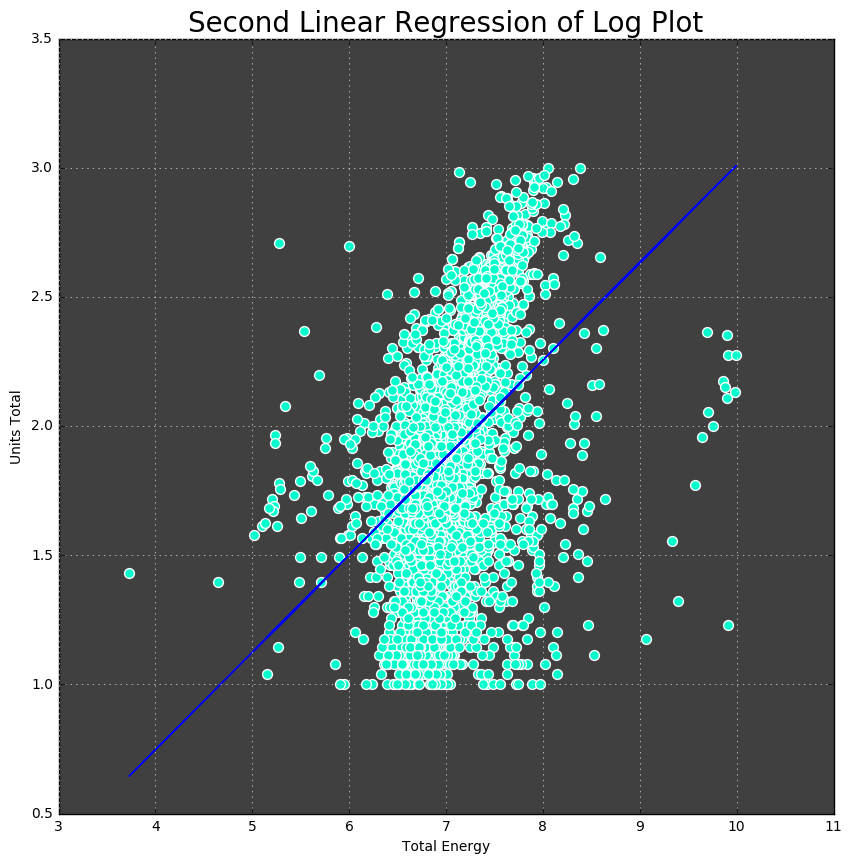

In [97]:
# plot second linear model on top of scatter plot
fig = pl.figure(figsize(10,10))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#404040')
pl.scatter(np.log10(bblnrgdata_cut['TotalEnergy']), np.log10(bblnrgdata_cut['UnitsTotal']), s=50, facecolors='#00ffcc', edgecolors='white')
pl.plot(np.log10(bblnrgdata_cut['TotalEnergy']), linmodel1.predict())
pl.ylabel('Units Total')
pl.xlabel('Total Energy')
pl.grid(color = '#e6e6e6')
pl.title("Second Linear Regression of Log Plot", fontsize = 20)

### Chi Square Analysis of Data

In [98]:
# define prediction variables
predict_1 = np.ndarray.tolist(linmodel.predict())
predict_2 = np.ndarray.tolist(linmodel1.predict())

#create new dataframe for chisquare table
chisq = pd.DataFrame({'LogUnits': np.log10(bblnrgdata_cut.UnitsTotal),
                  'LogEnergy': np.log10(bblnrgdata_cut.TotalEnergy),
                  'Prediction1': np.ndarray.tolist(linmodel.predict()), 
                  'Prediction2': np.ndarray.tolist(linmodel1.predict())})
chisq.head(3)

,LogEnergy,LogUnits,Prediction1,Prediction2
2,7.616811,1.748188,6.954402,2.110566
16,7.629287,1.380211,6.782182,2.115270
18,7.286094,1.380211,6.782182,1.985877


In [99]:
chisq['Error1'] = np.sqrt(chisq['LogEnergy'])
chisq['Error2'] = np.sqrt(chisq['LogUnits'])
chisq['ChiSquare1'] = (chisq['Prediction1'] - chisq['LogEnergy'])**2/(chisq['Error1']**2)
chisq['ChiSquare2'] = (chisq['Prediction2'] - chisq['LogUnits'])**2/(chisq['Error2']**2)
chisq.head(3)

,LogEnergy,LogUnits,Prediction1,Prediction2,Error1,Error2,ChiSquare1,ChiSquare2
2,7.616811,1.748188,6.954402,2.110566,2.759857,1.322191,0.057608,0.075117
16,7.629287,1.380211,6.782182,2.115270,2.762116,1.174824,0.094057,0.391470
18,7.286094,1.380211,6.782182,1.985877,2.699277,1.174824,0.034851,0.265779


In [100]:
print ('Chi Square Model 1 = '+ str(chisq['ChiSquare1'].sum()))
print ('Chi Square Model 2 = '+ str(chisq['ChiSquare2'].sum()))

Chi Square Model 1 = 95.6276693505
Chi Square Model 2 = 350.457726957


### Fit 2nd Degree Polynomial Model:

In [35]:
# first define line function
def line(x, pars, err=False):
    '''
    Function that created a line given an independent variable and parameters 
    Arguments:
    x: series of IV values
    pars: series of 2 numbers : slope and intercept
    Return:
     array of DV values
    '''
    if err:
        err = np.random.randn(len(x)) * err
    else:
        err = np.zeros_like(x)
    return pars[0] * x + pars[1] + err, err

In [61]:
# set parameters to data
x = logunits
y = lognrg
xyd = pd.DataFrame()
xyd['X'] = x
xyd['y'] = y
xyd['X2'] = x*x

cres = smf.ols(formula = 'y ~ X2 + X', data=xyd).fit()

In [101]:
# create data frame for this model
xyd2 = pd.DataFrame()
xyd2['X'] = np.linspace(x.min(), x.max(), 100)
xyd2['X2'] = xyd2['X'] * xyd2['X']

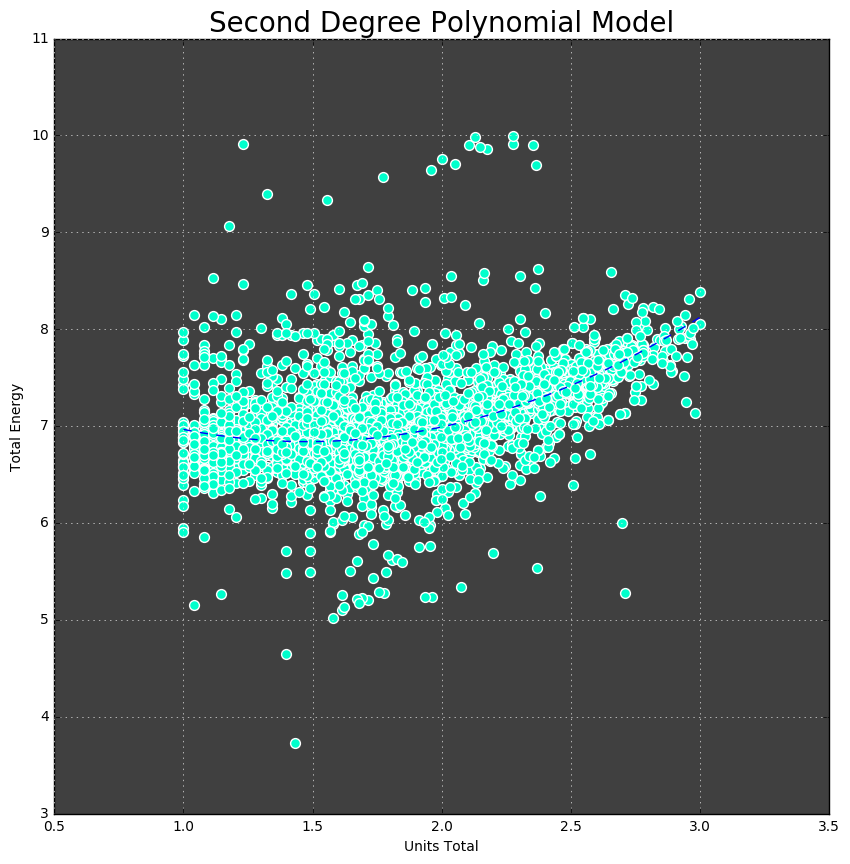

In [103]:
# plot polynomial model to data
fig = pl.figure(figsize(10,10))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('#404040')
pl.scatter(logunits, lognrg, s=50, facecolors='#00ffcc', edgecolors='white')
curve = pl.plot(xyd2['X'], cres.predict(xyd2), '--')
pl.xlim(0.5, 3.5)
pl.ylim(3, 11)
pl.ylabel('Total Energy')
pl.xlabel('Units Total')
pl.grid(color = '#e6e6e6')
pl.title("Second Degree Polynomial Model", fontsize = 20)

### Compare Units vs Energy line fit and the Units vs Energy 2nd degree polynomial fit with the Likelihood ratio test

In [78]:
print (linmodel.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalEnergy   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     907.8
Date:                Sat, 15 Oct 2016   Prob (F-statistic):          7.05e-181
Time:                        12:43:09   Log-Likelihood:                -2151.1
No. Observations:                4239   AIC:                             4306.
Df Residuals:                    4237   BIC:                             4319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1362      0.030    205.065      0.0

In [77]:
print (cres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     691.2
Date:                Sat, 15 Oct 2016   Prob (F-statistic):          1.64e-260
Time:                        12:42:32   Log-Likelihood:                -1964.0
No. Observations:                4239   AIC:                             3934.
Df Residuals:                    4236   BIC:                             3953.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.0474      0.101     79.831      0.0

In [108]:
# find likelihood ratio
LR = (-2) * (-2151.1 - -1964.0)
print ("Likelihood Ratio: " + str(LR))

Likelihood Ratio: 374.2
